In [7]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel as C
from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
class GPR():
    def __init__(self, kernel, alpha=1e-10, n_restarts_optimizer=1):
        self.gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, n_restarts_optimizer=20)

    def fit(self, X, Y):
        self.X=X
        self.Y=Y
        self.n_features=np.shape(self.X)[1]
        self.n_samples=np.shape(self.X)[0]
        gp_ = self.gp.fit(self.X, self.Y)

        self.kernel_ = gp_.kernel_

        self.length_scales=self.kernel_.get_params()['k1__k2__length_scale']

        self.noise_var_ = gp_.alpha + self.kernel_.get_params()['k2__noise_level']

        self.max_var   = self.kernel_.get_params()['k1__k1__constant_value']+ self.noise_var_
        
        self.kernel_params_= [self.kernel_.get_params()['k1__k2__length_scale'], self.kernel_.get_params()['k1']]

        K_ = self.kernel_(self.X, self.X) + (self.noise_var_ * np.eye(len(self.X)))
        
        self.K_inv = np.linalg.inv(K_)

    def predict(self, x, return_std=True):
        k_star = self.kernel_(self.X, x)
        print(k_star.shape)
        k_star_K_inv_ = np.transpose(k_star) @ self.K_inv
        self.mu=k_star_K_inv_ @ self.Y
        self.sigma=None
        if return_std==True:
            self.sigma = self.kernel_(x, x)+ self.noise_var_ -  k_star_K_inv_ @ k_star
            
        self.std= np.sqrt(self.sigma)    
        return self.mu, self.std 
    
    def predict_derivative(self, x):
        """Input has shape n_query x n_features. 
        There are two outputs,
        1. mean of the derivative function 
        2. predicted standar deviation of the function derivative
        Each utput has shape n_query x n_features x n_outputs.
        The output in position i,j,k has the derivative respect to the j-th feature of the k-th output, in position of the i-th data point.
        For the derivative of sigma n_outputs is equal to 1"""
        lscale=self.kernel_params_[0].reshape(-1,1)
        lscale_stack= np.hstack([lscale]*self.n_samples)
        alfa=  np.matmul(self.K_inv, self.Y)
        dy_dx=[]
        dsigma_dx=[]
        for i in range(np.shape(x)[0]):
            k_star= self.kernel_(self.X, x[i,:].reshape(1,-1))
            k_star_T=k_star.transpose()
            k_star_stack= np.vstack([k_star_T]*self.n_features)
            dk_star_dX= k_star_stack * (self.X- x[i,:]).transpose()/ (lscale_stack** 2)
            dy_dx.append(dk_star_dX @ alfa)     
            dk_star_dX_K_inv_= dk_star_dX @  self.K_inv  
            var_der=self.max_var/(lscale**2) - dk_star_dX_K_inv_ @ dk_star_dX.transpose()
            dsigma_dx.append(np.sqrt(var_der))
        return np.array(dy_dx), np.array(dsigma_dx)

(20, 50)


/home/oem/venv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
<ipython-input-14-6a0377628897>:35: RuntimeWarning: invalid value encountered in sqrt
  self.std= np.sqrt(self.sigma)


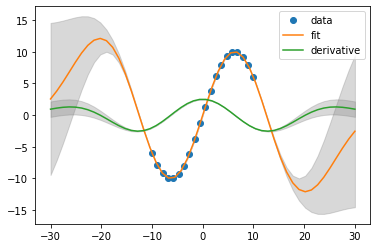

In [16]:
X=np.linspace(-10,10,20)
Y=10 * np.sin(X/4)
X=X.reshape(-1,1)
Y=Y.reshape(-1,1)
plt.plot(X,Y, 'o')
k = C(constant_value=1)  * RBF(1*np.ones(1)) + WhiteKernel(0.01 )
gp=GPR(kernel=k)
gp.fit(X,Y)
X_test=np.linspace(-30,30,50).reshape(-1,1)
Y_pred, std =gp.predict(X_test)

Y_der, std_derivative=gp.predict_derivative(X_test)
plt.plot(X_test, Y_pred)
plt.plot(X_test, Y_der[:,0,0])
plt.fill_between(X_test.reshape(-1,), Y_pred.reshape(-1,)-np.diag(std), Y_pred.reshape(-1,)+np.diag(std), color='gray', alpha=0.3)
plt.fill_between(X_test.reshape(-1,), Y_der[:,0,0]-std_derivative.reshape(-1,), Y_der[:,0,0]+std_derivative.reshape(-1,), color='gray', alpha=0.3)
plt.legend(["data","fit","derivative"])